# Lab | Making predictions with logistic regression

### 1.Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

In [82]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [116]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT DISTINCT(f.title), f.length, f.rating, c.name AS 'category', f.rental_rate, f.rental_duration, f.replacement_cost 
FROM film as f
LEFT JOIN film_category as fc
on f.film_id = fc.film_id 
LEFT JOIN category as c
ON fc.category_id = c.category_id
LEFT JOIN inventory as i
ON f.film_id = i.film_id;'''

data1 = pd.read_sql_query(query, engine)
display(data1.head())
display(data1.shape)

,title,length,rating,category,rental_rate,rental_duration,replacement_cost
0,ACADEMY DINOSAUR,86,PG,Documentary,0.99,6,20.99
1,ACE GOLDFINGER,48,G,Horror,4.99,3,12.99
2,ADAPTATION HOLES,50,NC-17,Documentary,2.99,7,18.99
3,AFFAIR PREJUDICE,117,G,Horror,2.99,5,26.99
4,AFRICAN EGG,130,G,Family,2.99,6,22.99


(1000, 7)

The columns above was chosen as the infomation to build for the prediction model:'title', 'length', 'rating', 'name', 'rental-rate','rental_duration','replacem,ent_cost'. 

In addition, the data of film titles which were rented in May 2005 is extracted. 

In [118]:
query = '''SELECT DISTINCT(f.title)
FROM inventory as i
JOIN rental as r
On i.inventory_id = r.inventory_id
JOIN film as f
ON i.film_id = f.film_id
JOIN film_category as fc
on f.film_id = fc.film_id
JOIN category as c
ON fc.category_id = c.category_id
WHERE YEAR(r.rental_date) = 2005 AND MONTH(r.rental_date) = 05;'''

data2 = pd.read_sql_query(query, engine)
display(data2.head())
display(data2.shape)

,title
0,AMADEUS HOLY
1,AMERICAN CIRCUS
2,ANTITRUST TOMATOES
3,BAREFOOT MANCHURIAN
4,BERETS AGENT


(686, 1)

### 2.Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [188]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT DISTINCT(f.title), f.length, f.rating, c.name AS 'category', f.rental_rate, f.rental_duration, f.replacement_cost,
case when f.title in 
(SELECT DISTINCT(f.title)
FROM inventory as i
JOIN rental as r
On i.inventory_id = r.inventory_id
JOIN film as f
ON i.film_id = f.film_id
JOIN film_category as fc
on f.film_id = fc.film_id
JOIN category as c
ON fc.category_id = c.category_id
WHERE YEAR(r.rental_date) = 2005 AND MONTH(r.rental_date) = 05)
then true 
else false end as rented_in_may
FROM film as f
LEFT JOIN film_category as fc
on f.film_id = fc.film_id 
LEFT JOIN category as c
ON fc.category_id = c.category_id
LEFT JOIN inventory as i
ON f.film_id = i.film_id;'''

data = pd.read_sql_query(query, engine)
data.head()

,title,length,rating,category,rental_rate,rental_duration,replacement_cost,rented_in_may
0,ACADEMY DINOSAUR,86,PG,Documentary,0.99,6,20.99,1
1,ACE GOLDFINGER,48,G,Horror,4.99,3,12.99,0
2,ADAPTATION HOLES,50,NC-17,Documentary,2.99,7,18.99,1
3,AFFAIR PREJUDICE,117,G,Horror,2.99,5,26.99,1
4,AFRICAN EGG,130,G,Family,2.99,6,22.99,1


In [189]:
data['rented_in_may'].value_counts()

1    686
0    314
Name: rented_in_may, dtype: int64

In [190]:
df = data
df.shape

(1000, 8)

### 3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [191]:
# search the data type
df.dtypes

title                object
length                int64
rating               object
category             object
rental_rate         float64
rental_duration       int64
replacement_cost    float64
rented_in_may         int64
dtype: object

In [193]:
# change the 'object' type of 'rented_in_may' into 'bool' type.

df['rented_in_may'] = df['rented_in_may'].astype(bool)
display(df['rented_in_may'].value_counts())
display(df.dtypes)


True     686
False    314
Name: rented_in_may, dtype: int64

title                object
length                int64
rating               object
category             object
rental_rate         float64
rental_duration       int64
replacement_cost    float64
rented_in_may          bool
dtype: object

In [194]:
# serach the null values
df.isna().sum()

title               0
length              0
rating              0
category            0
rental_rate         0
rental_duration     0
replacement_cost    0
rented_in_may       0
dtype: int64

In [195]:
# investigate each categorical values
df['title'].value_counts()

ACADEMY DINOSAUR    1
PERFECT GROOVE      1
PARK CITIZEN        1
PARTY KNOCK         1
PAST SUICIDES       1
                   ..
FROGMEN BREAKING    1
FRONTIER CABIN      1
FROST HEAD          1
FUGITIVE MAGUIRE    1
ZORRO ARK           1
Name: title, Length: 1000, dtype: int64

In [196]:
df['rating'].value_counts()

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64

In [197]:
df['category'].value_counts()

Sports         74
Foreign        73
Family         69
Documentary    68
Animation      66
Action         64
New            63
Drama          62
Sci-Fi         61
Games          61
Children       60
Comedy         58
Classics       57
Travel         57
Horror         56
Music          51
Name: category, dtype: int64

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns

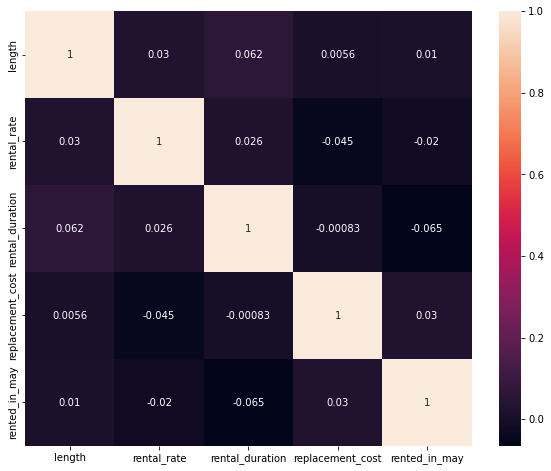

In [199]:
# look for multicolinearity (some columns having almost identical correlation to other variables)
# why can't we look for correlation with our target variable (status)?
corr_matrix=df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

It shows no multicolinearity in this case. 

In [200]:
# investigate numerical values
df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,1000.0,115.272,40.426332,46.00,80.00,114.00,149.25,185.00
rental_rate,1000.0,2.980,1.646393,0.99,0.99,2.99,4.99,4.99
rental_duration,1000.0,4.985,1.411654,3.00,4.00,5.00,6.00,7.00
replacement_cost,1000.0,19.984,6.050833,9.99,14.99,19.99,24.99,29.99


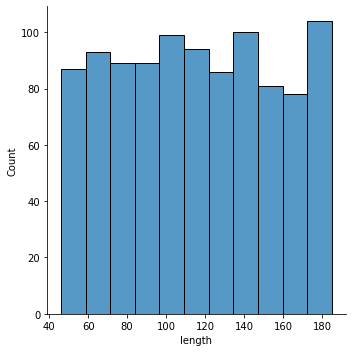

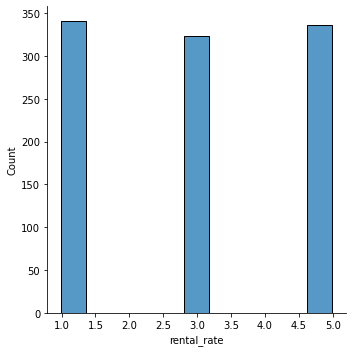

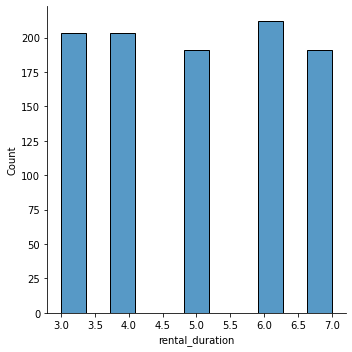

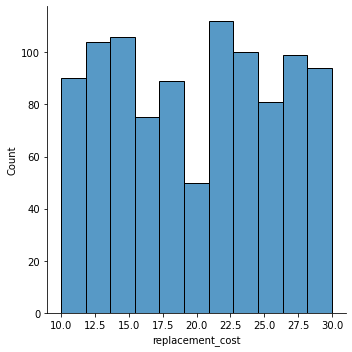

In [201]:
import numpy as np

def plot_distributions(df):
    numerical_columns = df.select_dtypes(np.number)
    for col in numerical_columns:
        sns.displot(df[col])
        plt.show()

plot_distributions(df)

The scale of 'length' is different from others. Therefore, scaling needs to be done later. When it comes to transformation, there is no need to be used this time. 

In [202]:
#analyse 'rental_rate' and 'rental_duration'
pd.crosstab(df['rental_rate'],df['rental_duration'])

rental_duration,3,4,5,6,7
rental_rate,,,,,
0.99,78,72,56,76,59
2.99,63,61,59,70,70
4.99,62,70,76,66,62


In [203]:
pd.crosstab(df['rental_rate'],df['category'])

category,Action,Animation,Children,Classics,Comedy,Documentary,Drama,Family,Foreign,Games,Horror,Music,New,Sci-Fi,Sports,Travel
rental_rate,,,,,,,,,,,,,,,,
0.99,28,23,21,22,16,29,23,26,21,19,20,20,20,15,22,16
2.99,19,26,21,20,21,21,15,25,27,15,15,12,19,24,25,18
4.99,17,17,18,15,21,18,24,18,25,27,21,19,24,22,27,23


Although values of 'rental rate' and 'rental-duration' are numerical, they will ve treated as categorical becuase there are only 3 types and 5 types respectively.

In [204]:
df['rental_rate'] = df['rental_rate'].astype('object')
df['rental_duration'] = df['rental_duration'].astype('object')
df.dtypes

title                object
length                int64
rating               object
category             object
rental_rate          object
rental_duration      object
replacement_cost    float64
rented_in_may          bool
dtype: object

In [205]:
df['rented_in_may'].value_counts()

True     686
False    314
Name: rented_in_may, dtype: int64

### 4.Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [207]:
# use x/y split
data = df.copy()

y = data['rented_in_may']
X = data.drop('rented_in_may', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500)


In [208]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)
X_test_num  = X_test.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer

X_train_normalized = transformer.transform(X_train_num)
X_test_normalized  = transformer.transform(X_test_num)

X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns, index= X_train_num.index)
X_test_norm  = pd.DataFrame(X_test_normalized, columns=X_test_num.columns, index= X_test_num.index)

In [209]:
#check
X_train_norm.describe()

,length,replacement_cost
count,800.000000,800.000000
mean,0.501538,0.497125
std,0.293907,0.303326
min,0.000000,0.000000
25%,0.244604,0.200000
50%,0.500000,0.500000
75%,0.748201,0.750000
max,1.000000,1.000000


In [210]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,length,replacement_cost
313,0.323741,0.20
921,0.438849,0.65
628,0.589928,0.00
520,0.726619,0.95
648,0.280576,0.25


In [211]:
#categorical values 

X_train_categorical = X_train.select_dtypes('object')
X_test_categorical  = X_test.select_dtypes('object')

from sklearn.preprocessing import OneHotEncoder



encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

encoder.fit(X_train_categorical)

X_train_cat_np = encoder.transform(X_train_categorical).toarray()
X_test_cat_np  = encoder.transform(X_test_categorical).toarray()

X_train_cat = pd.DataFrame(X_train_cat_np, columns=encoder.get_feature_names_out(), 
                           index=X_train_categorical.index)
X_test_cat  = pd.DataFrame(X_test_cat_np,  columns=encoder.get_feature_names_out(),
                          index=X_test_categorical.index)


X_train_cat.head()

/Users/soichirotanabe/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_AIRPORT POLLOCK,title_ALABAMA DEVIL,title_ALADDIN CALENDAR,title_ALAMO VIDEOTAPE,title_ALASKA PHANTOM,title_ALI FOREVER,...,category_New,category_Sci-Fi,category_Sports,category_Travel,rental_rate_2.99,rental_rate_4.99,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7
313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [212]:
#concatanate the numerical data and the categorical data.
X_train_transformed = pd.concat([X_train_norm, X_train_cat], axis=1)
X_test_transformed = pd.concat([X_test_norm, X_test_cat], axis=1)
X_train_transformed

,length,replacement_cost,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_AIRPORT POLLOCK,title_ALABAMA DEVIL,title_ALADDIN CALENDAR,title_ALAMO VIDEOTAPE,...,category_New,category_Sci-Fi,category_Sports,category_Travel,rental_rate_2.99,rental_rate_4.99,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7
313,0.323741,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
921,0.438849,0.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
628,0.589928,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
520,0.726619,0.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
648,0.280576,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,0.978417,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
273,0.151079,0.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
833,0.755396,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
951,0.762590,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### 5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [214]:
# Use classification model.
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial')

classification.fit(X_train_transformed, y_train)

LogisticRegression(multi_class='multinomial', random_state=0, solver='saga')

In [218]:
# Make predictions on the test set:
y_test_pred = classification.predict(X_test_transformed)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,y_test_pred))

0.72


### 6. Evaluate the results.

In [219]:
print(y_test.value_counts())

True     146
False     54
Name: rented_in_may, dtype: int64


/Users/soichirotanabe/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


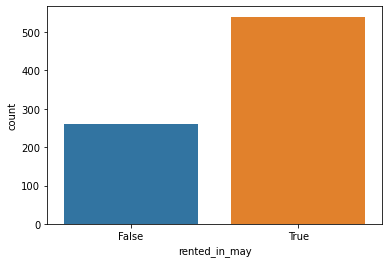

In [220]:
sns.countplot(y_train)
plt.show()

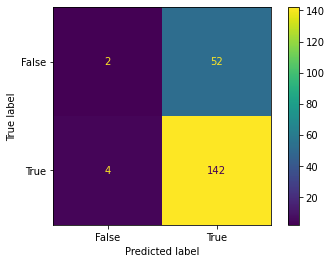

In [222]:
# confusion Matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_)
disp.plot()
plt.show()

In [223]:
# use kappa 
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_test_pred)

0.013389711064129783

 a Cohen's kappa score of 0.013389711064129783 is quite low, indicating only slight agreement beyond chance. This suggests that the predicted labels from this logistic regression model have limited agreement with the true labels.

In [224]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.33      0.04      0.07        54
        True       0.73      0.97      0.84       146

    accuracy                           0.72       200
   macro avg       0.53      0.50      0.45       200
weighted avg       0.62      0.72      0.63       200

